<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/gammaFitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gamma
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

%config InlineBackend.figure_format = 'retina'

In [ ]:
# Example for Gamma distribution
# Define function for example
def GammaPlot(n, k):
  x = np.arange(1, n + 1)
  data = []
  for alpha in range(1, k + 1):
    for scale in range(1, k + 1):
      data.append([alpha, scale, gamma.cdf(x, alpha, 0, scale)])

  data = pd.DataFrame(data, columns = ['Alpha', 'Scale', 'Values'])
  
  with plt.style.context('seaborn'):
    fig, axs = plt.subplots(2, k * 2, figsize = (24, 10), sharex = True)
    fig.suptitle('Gamma Cumulative Density Function')
    axs = axs.ravel()
    for i in range(data.shape[0]):
      axs[i].set_title(f'Alpha: {data.iloc[i][0]:.2f}, Scale: {data.iloc[i][1]:.2f}')
      axs[i].plot(data.iloc[i][2], color = np.random.rand(3))
  plt.savefig(f'gammaExample.png')
  return plt.show() 

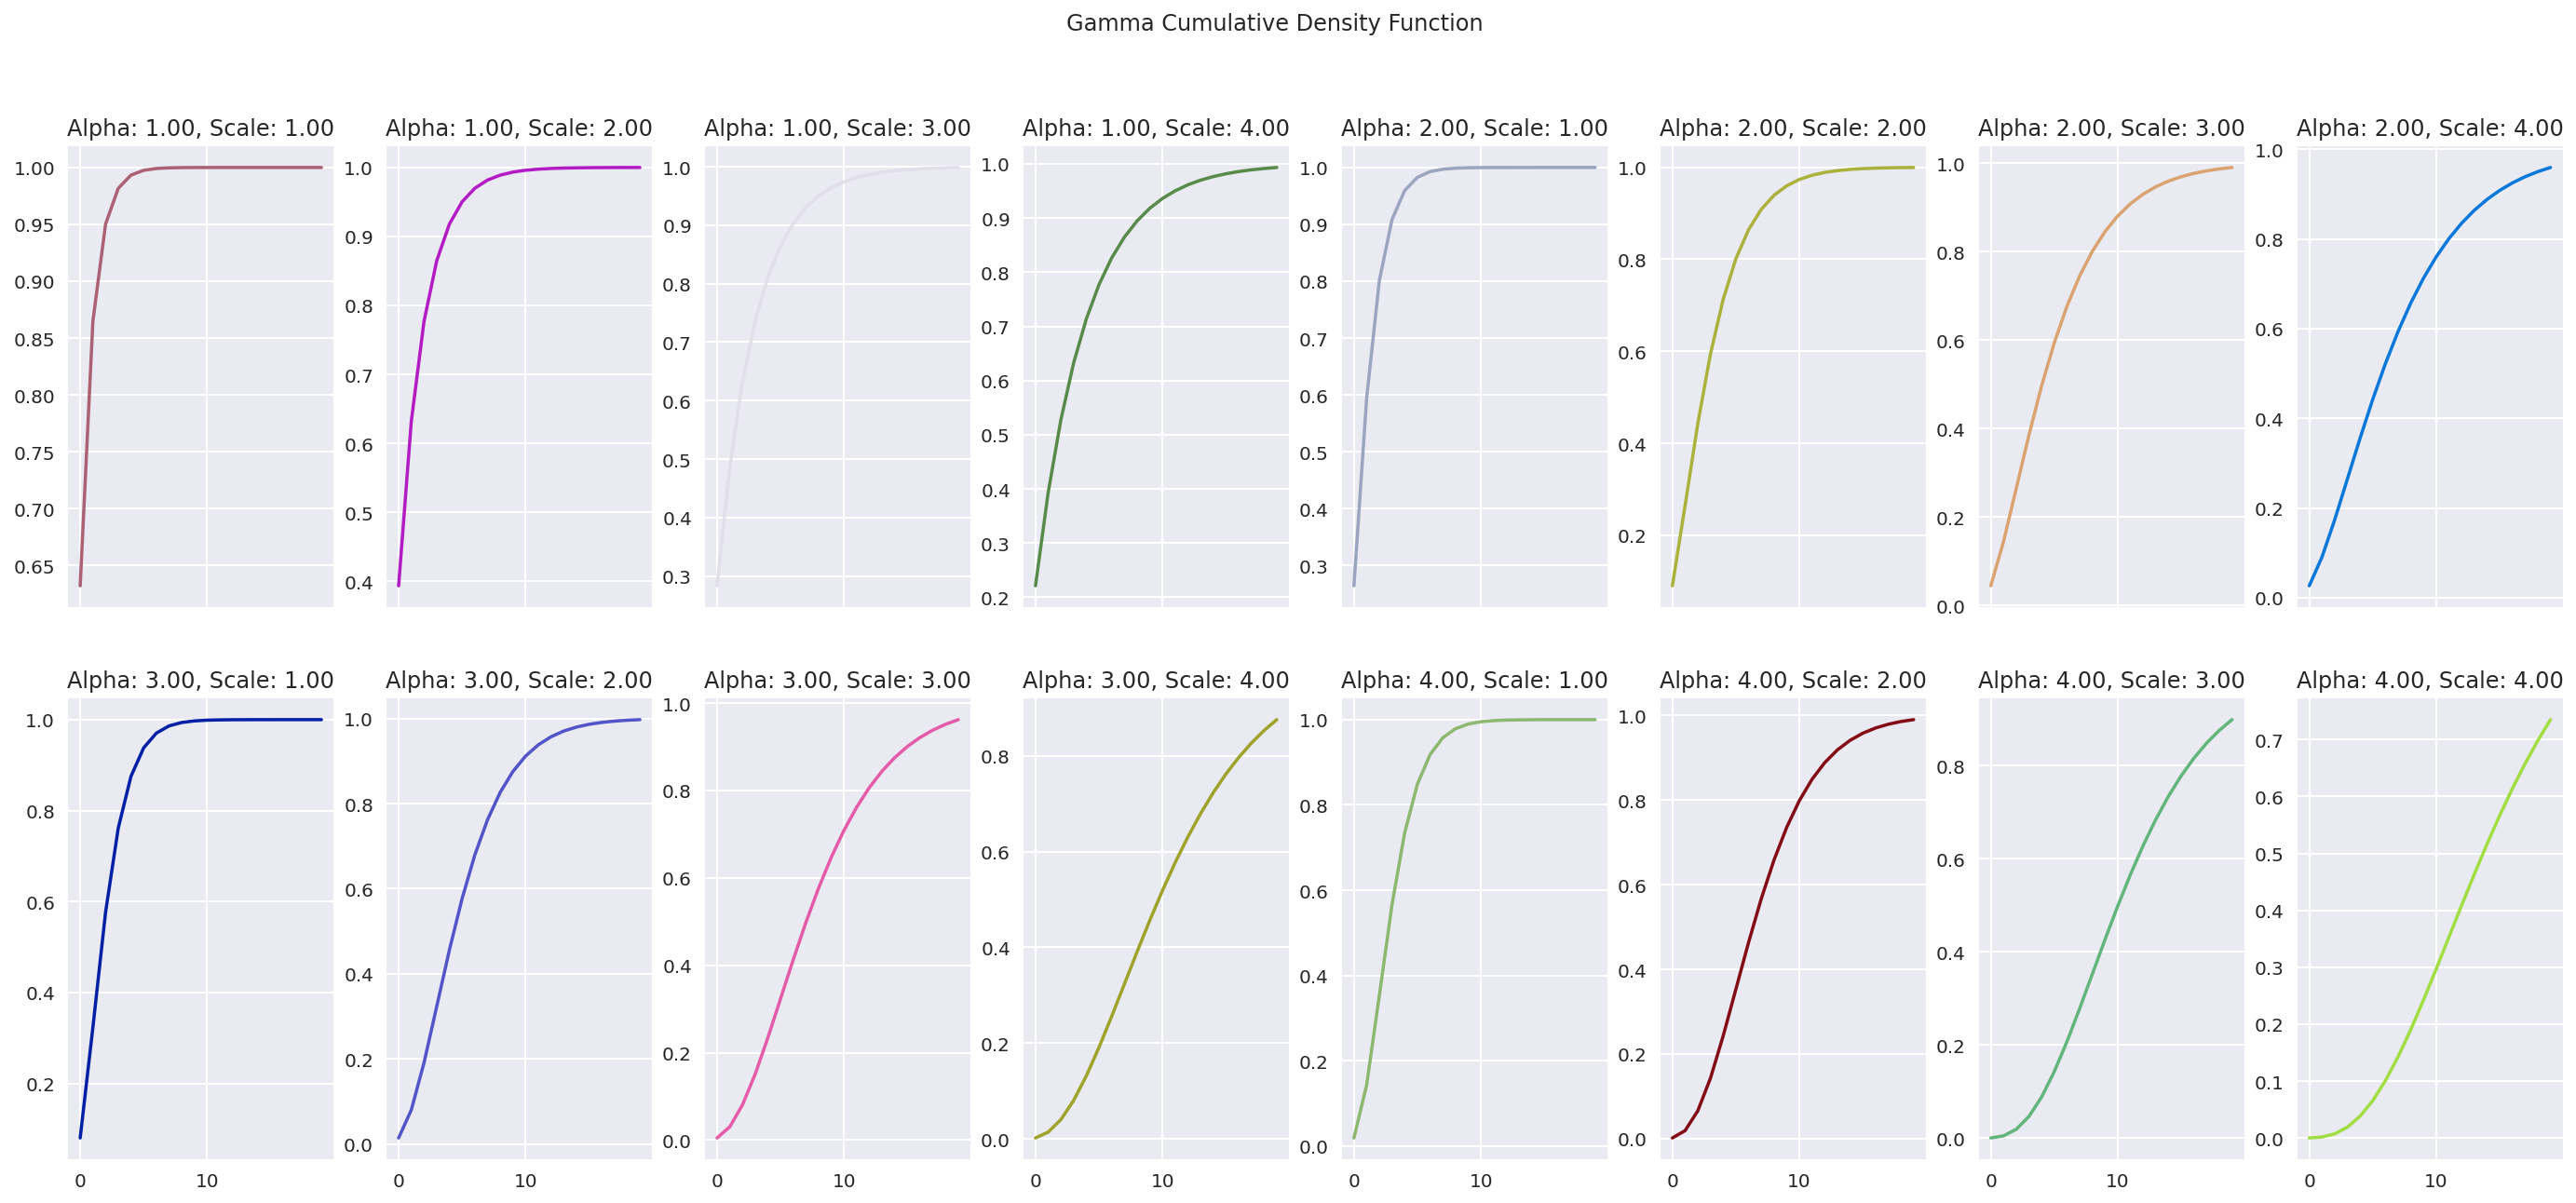

In [ ]:
# Cumulative Density Function
GammaPlot(20, 4)

In [ ]:
# Import dataset
df = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/PDRiskGrade.csv')
df = df.set_index(['Segment', 'Aging', 'N']) #Set index to avoid un-used columns
df

1         2  ...        59        60
Segment Aging N                            ...                    
CU      0     1425717  0.000038  0.000100  ...  0.070381  0.070581
        1     178034   0.000219  0.005308  ...  0.264745  0.265104
        2     73212    0.015530  0.084890  ...  0.455843  0.456415
        3     14363    0.431247  0.514865  ...  0.809061  0.809540
HU      0     4232680  0.000043  0.000116  ...  0.047413  0.047596
        1     423105   0.000340  0.003654  ...  0.223064  0.223404
        2     164827   0.011291  0.070431  ...  0.434217  0.434904
        3     30127    0.398181  0.479437  ...  0.792708  0.792938

[8 rows x 60 columns]

In [ ]:
# Defind Gamma Cumulative Densities Function
def gammaFitting(x, alphaEst, scaleEst, curveEst):
  return gamma.cdf(x, alphaEst, loc = 0, scale = scaleEst) * curveEst

# Initial guess for estimating parameters
initialGuess = [1, 1, 1] #Three paramaters to estimate

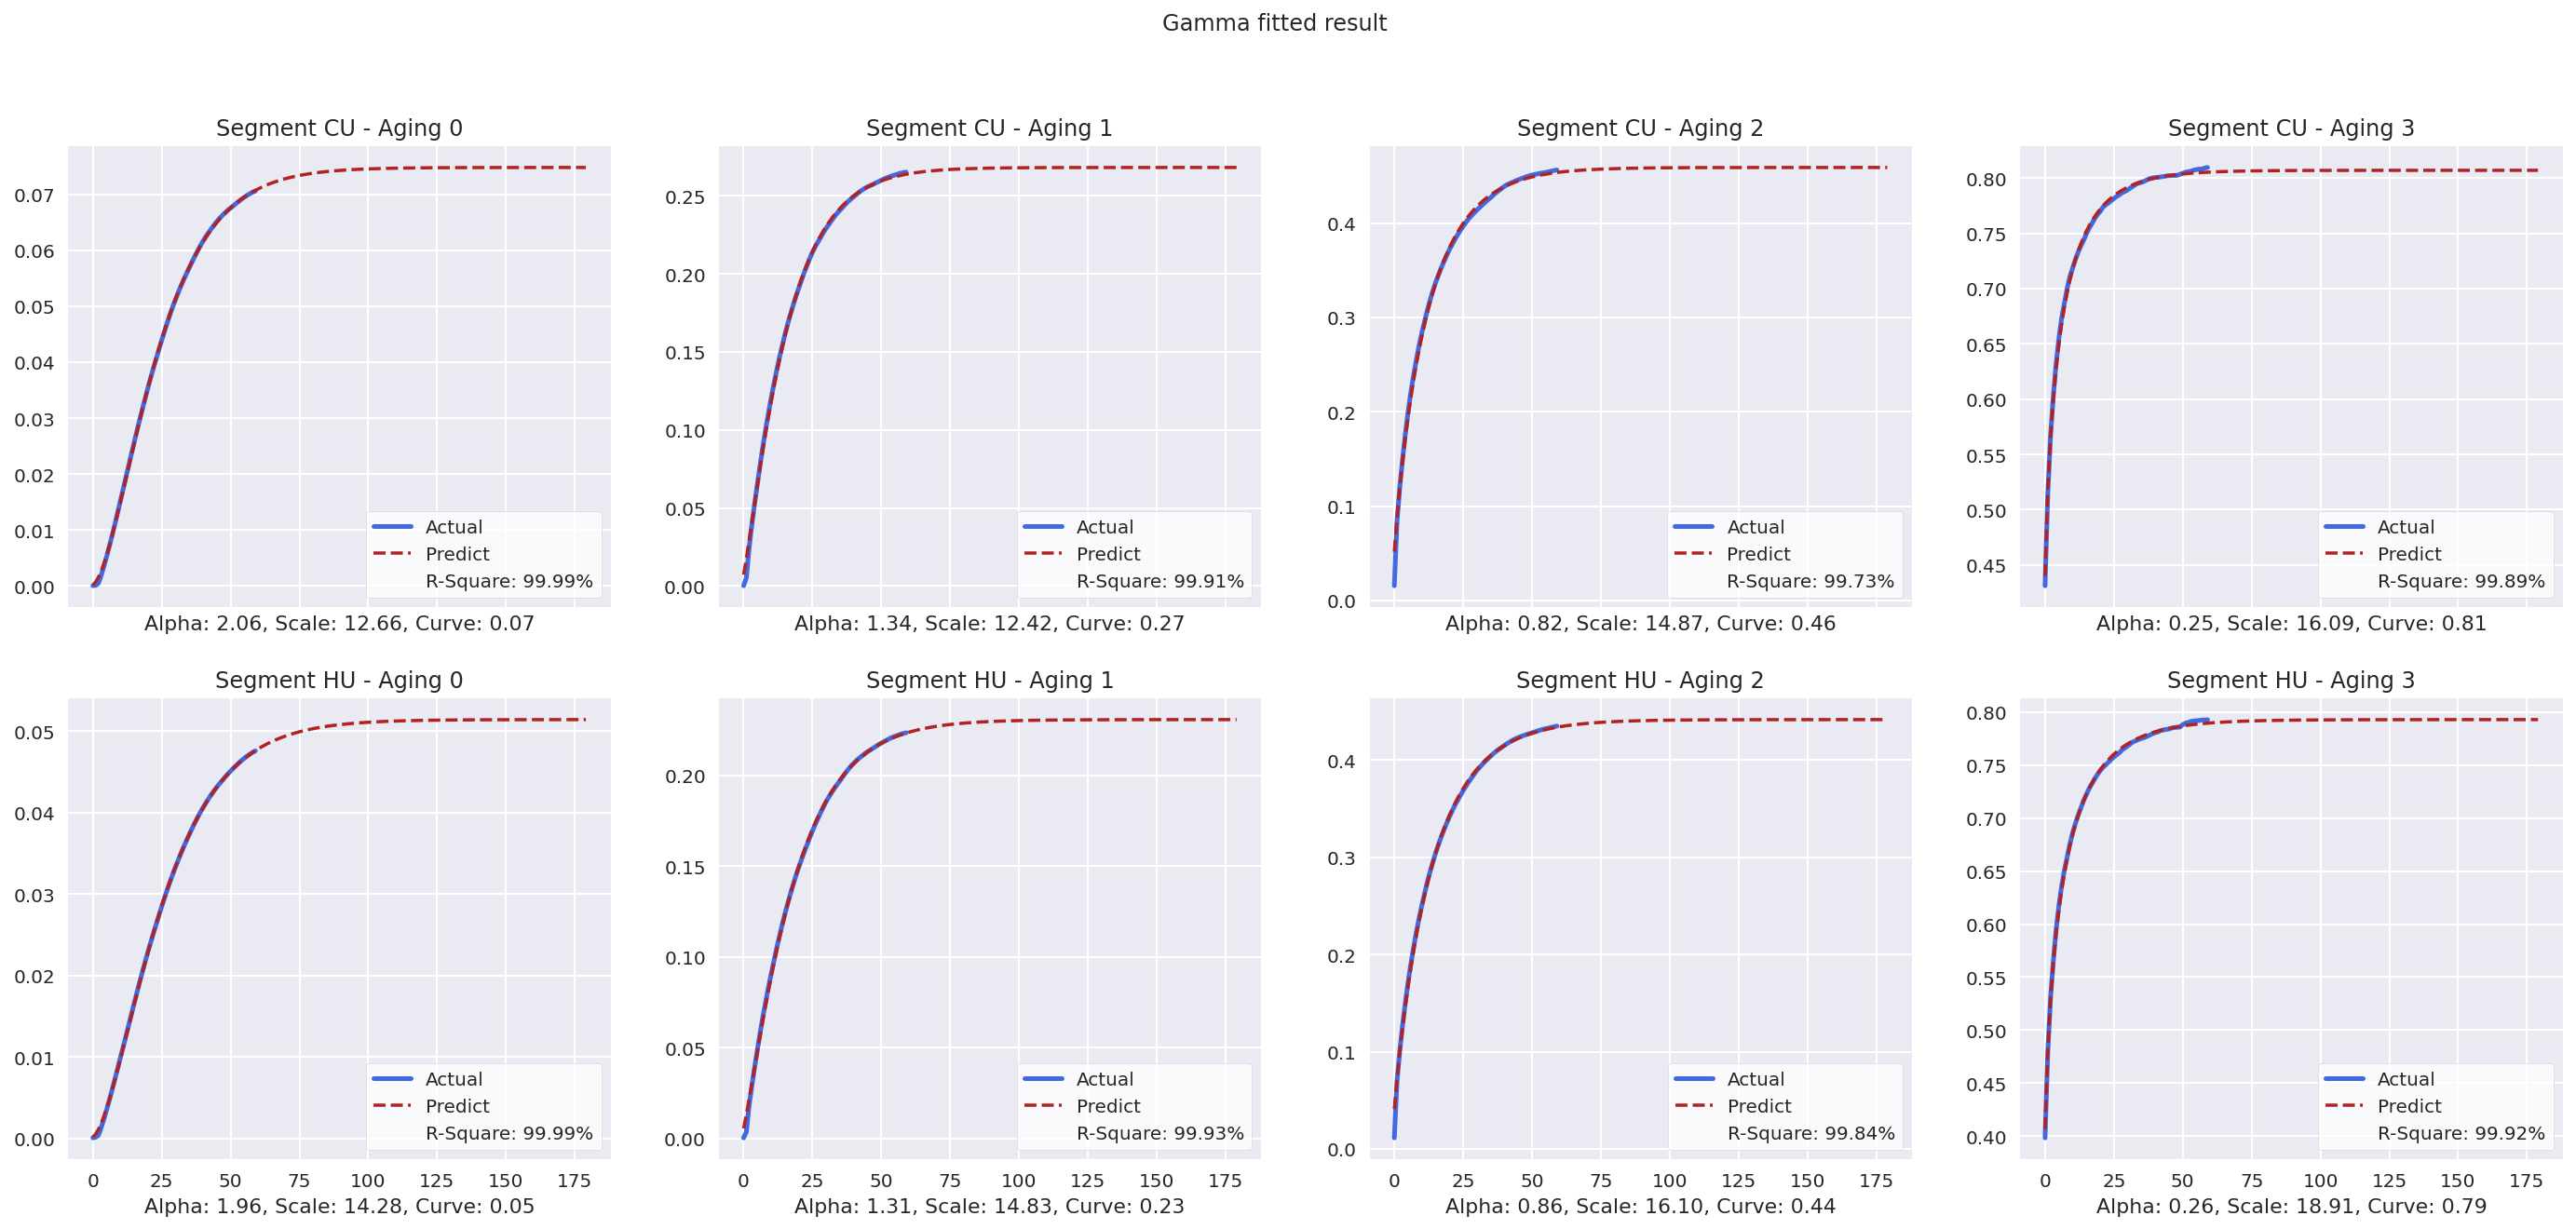

In [ ]:
# Iteration for gamma fitting
namePlot = [[i[0], i[1]] for i in df.index] #Segment and risk grade name
fittedPD = None

# Plot result
with plt.style.context('seaborn'):
  fig, axs = plt.subplots(2, len(namePlot) // 2, figsize = (24, 10), sharex = True)
  fig.suptitle('Gamma fitted result')
  axs = axs.ravel()

  for i, name in enumerate(namePlot):

    # Fitting variables
    odr = df.values[i]
    year = np.arange(1, odr.shape[0] + 1)

    # Curves fitting
    popt, _ = curve_fit(gammaFitting, year, odr, initialGuess, maxfev = 100000) #Increase iteration number

    # Estimating from fitted parameters
    n = 10 #Define estimation year (plus 10 Years)
    yearEst = np.arange(1, odr.shape[0] + n * 12 + 1) #Create lifetime PD
    fittedODR = [gammaFitting(x, *popt) for x in yearEst] #Fitted maginal PD
    score = r2_score(odr, fittedODR[0:odr.shape[0]]) #Using only avaliable data

    # Fitted result
    if fittedPD is None:
      fittedPD = np.array(fittedODR).reshape(1, -1).copy()
    else:
      fittedPD = np.vstack((fittedPD, np.array(fittedODR).reshape(1, -1)))
    
    # Plot
    axs[i].set_title(f'Segment {name[0]} - Aging {name[1]}')
    axs[i].set_xlabel(f'Alpha: {popt[0]:.2f}, Scale: {popt[1]:.2f}, Curve: {popt[2]:.2f}')
    axs[i].plot(odr, c = 'royalblue', linewidth = 2.5, label = 'Actual')
    axs[i].plot(fittedODR, c = 'firebrick', linestyle = '--', label = 'Predict')
    axs[i].plot([], [], ' ', label = f'R-Square: {score * 100:.2f}%')
    axs[i].legend(frameon = True, facecolor = 'white')

plt.savefig(f'gammaFitted.png')
plt.show()  

In [ ]:
# Fitted table
fittedTable = pd.DataFrame(fittedPD)
fittedTable.columns = [x for x in range(1, fittedTable.shape[1] + 1)] #Change columns name and type
fittedTable.index = df.index #Set index from initial table

# Cap maximum PD as 100%
fittedTable[fittedTable > 1] = 1

# Export
fittedTable.to_csv('extrapolateByRisk.csv')

In [ ]:
# Table combination with actual ODR
# Fitted table
comparedTable = pd.melt(fittedTable.reset_index(level = ['Segment', 'Aging']),
                        id_vars = ['Segment', 'Aging'],
                        var_name = 'times',
                        value_name = 'cumPD')
comparedTable = comparedTable.sort_values(by = ['Segment', 'Aging', 'times'])
comparedTable['PDTypes'] = 'fittedPD' #Key categorical

# Actual table
dfActual = pd.melt(df.reset_index(level = ['Segment', 'Aging']),
                   id_vars = ['Segment', 'Aging'],
                   var_name = 'times',
                   value_name = 'cumPD')
dfActual['times'] = dfActual['times'].astype(np.int8) #Change data type
dfActual = dfActual.sort_values(by = ['Segment', 'Aging', 'times'])
dfActual['PDTypes'] = 'actualPD' #Key categorical

# Concat table
comparedTable = pd.concat([comparedTable, dfActual],
                          axis = 0,
                          ignore_index = True)
comparedTable = comparedTable.sort_values(by = ['Segment', 'Aging', 'PDTypes', 'times']) #For better plot

# Marginal PD
comparedTable['marPD'] = comparedTable.groupby(['Segment', 'Aging', 'PDTypes'])['cumPD'].diff().fillna(comparedTable['cumPD'])
comparedTable.head(5)

,Segment,Aging,times,cumPD,PDTypes,marPD
1440,CU,0,1,0.000038,actualPD,0.000038
1441,CU,0,2,0.000100,actualPD,0.000062
1442,CU,0,3,0.000475,actualPD,0.000375
1443,CU,0,4,0.001878,actualPD,0.001404
1444,CU,0,5,0.003492,actualPD,0.001614


In [ ]:
# Define plot function
def plotCompare(data, PDType):
  with plt.style.context('seaborn'):
    fig, axs = plt.subplots(1, 2, figsize = (20, 6), sharey = True)
    axs = axs.ravel()

    for i, segment in enumerate(data['Segment'].unique()):

      # Data selection
      selectData = data[data['Segment'] == segment]

      # Create name
      if PDType == 'cumPD':
        name = 'Cumulative PD'
      else:
        name = 'Marginal PD'

      # Plot
      fig.suptitle(f'{name}')
      sns.lineplot(x = 'times', y = PDType, data = selectData,
                  hue = 'Aging', style = 'PDTypes', legend = 'full',
                  palette = 'viridis', ci = None, ax = axs[i])
      axs[i].set_title(f'Segment {segment}')
      axs[i].set(xlabel = 'Time', ylabel = 'PD')
    plt.savefig(f'{name}.png')
  return plt.show()

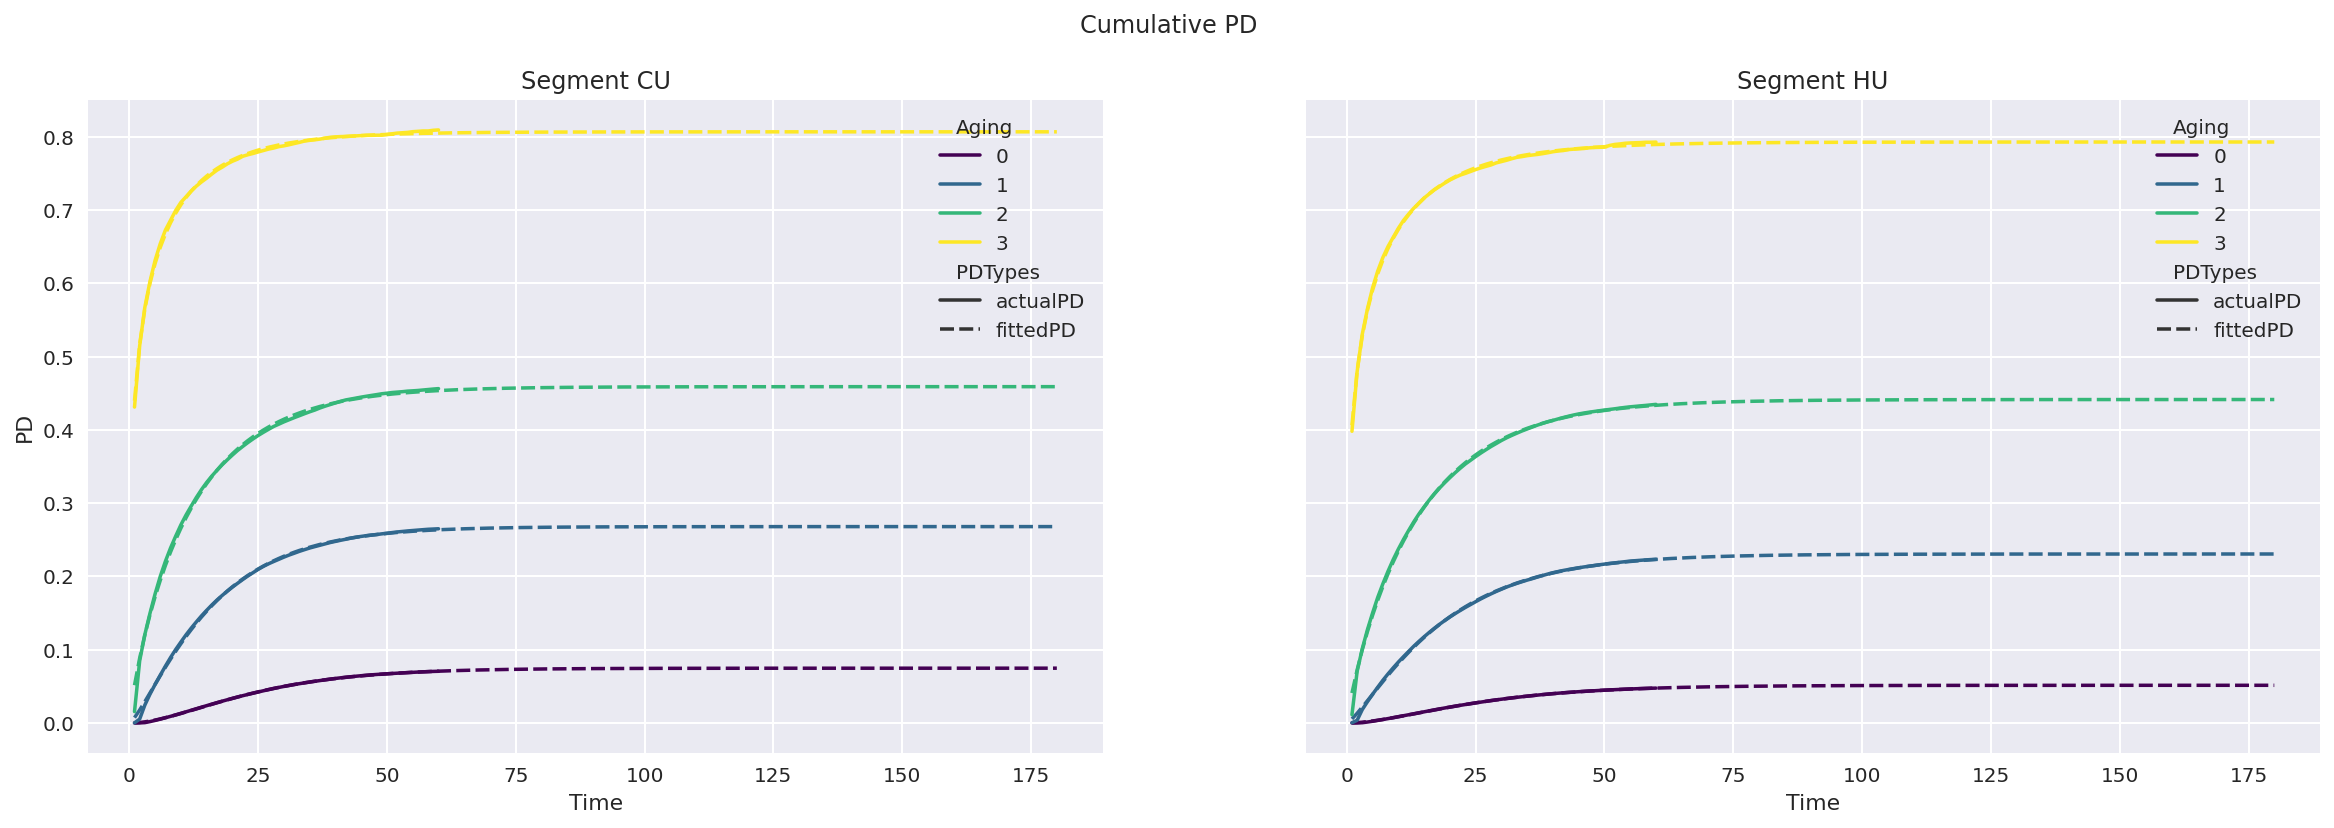

In [ ]:
# Plot cumulative
plotCompare(comparedTable, 'cumPD')

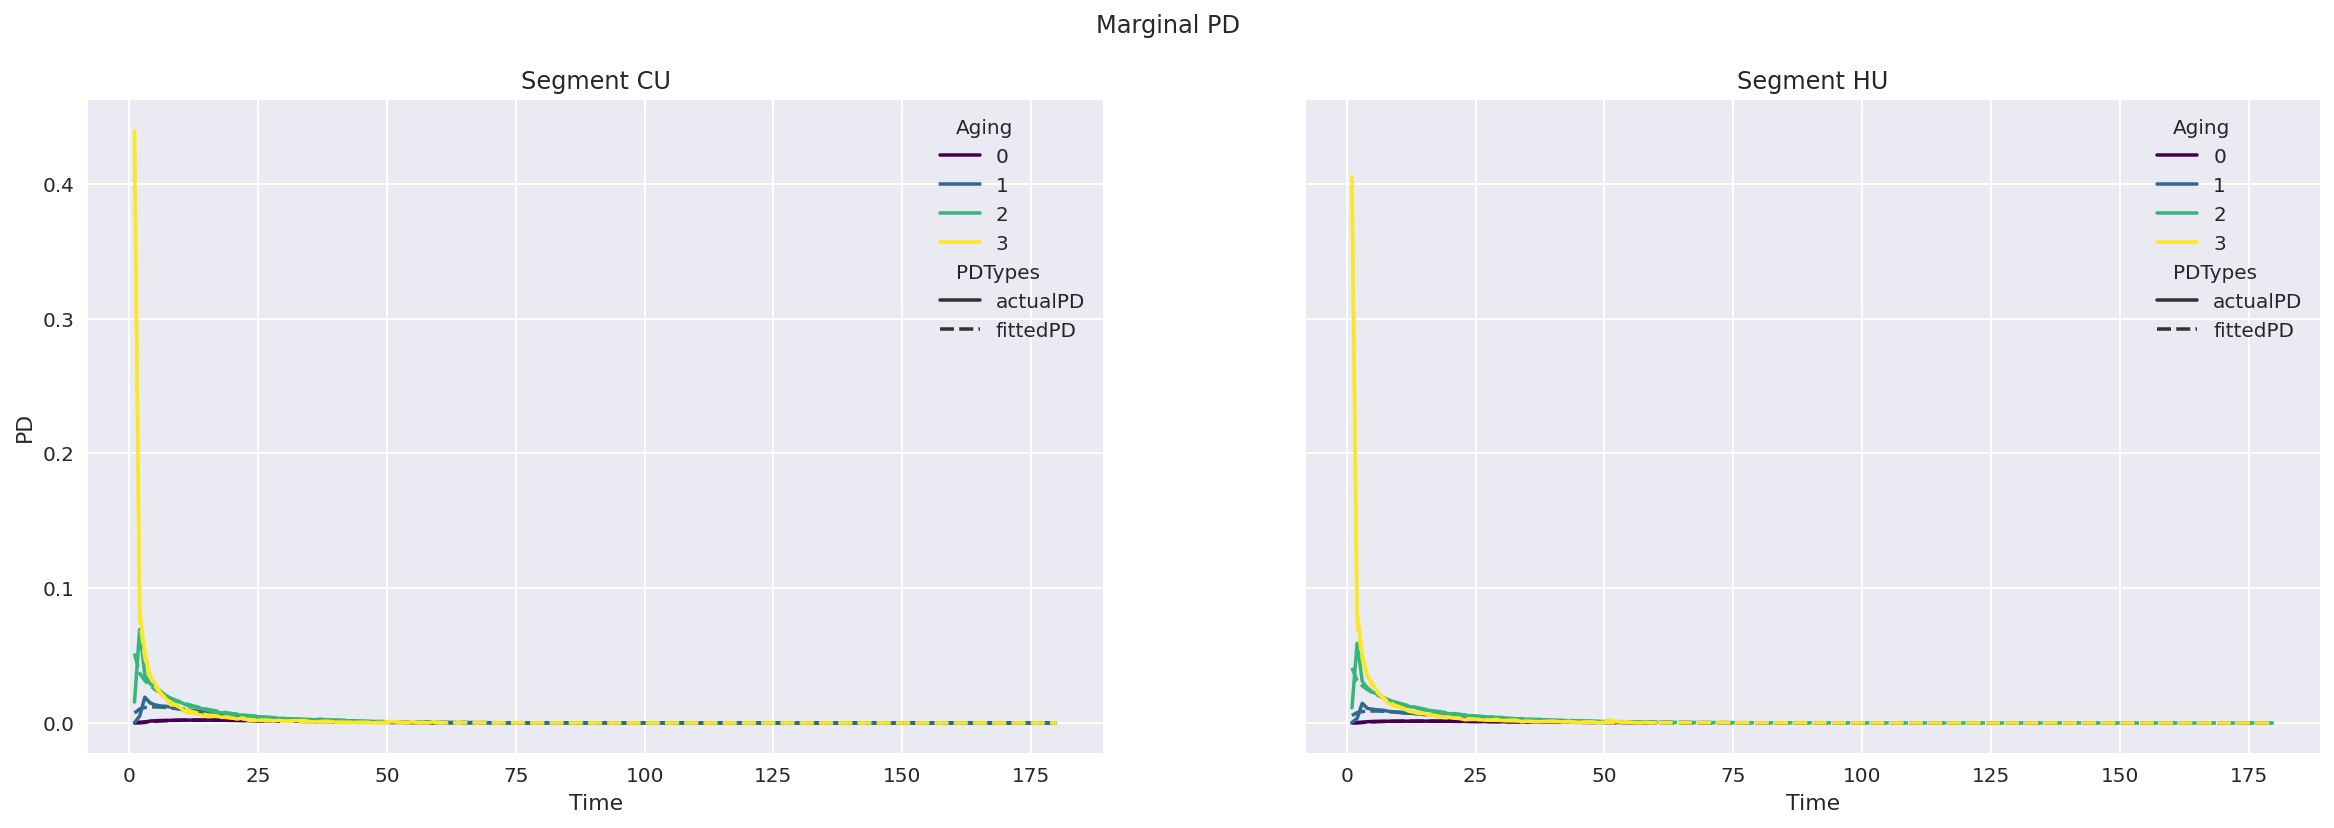

In [ ]:
# Plot marginal
plotCompare(comparedTable, 'marPD')

In [ ]:
# Average of extrapolated curves
fittedTable = fittedTable.reset_index()

# Weighted average
averageResult = []

for i in fittedTable.columns[3:]:
  selectData = fittedTable[['Segment', 'N', i]]
  average = selectData.groupby(['Segment']).apply(lambda x: np.average(x[i], weights = x['N']))
  average = average.rename(i)
  averageResult.append(average)

averageResult = pd.concat(averageResult, axis = 1).reset_index()
averageResult['N'] = list(fittedTable.groupby(['Segment'])['N'].sum()) #Get total number by segment
cols = averageResult.columns
cols = cols[0:1].append(cols[-1:]).append(cols[1:-1]) #Rearrange columns
averageResult = averageResult[cols]

# Expor result
averageResult.to_csv('averageExtrapolate.csv', index = 0)

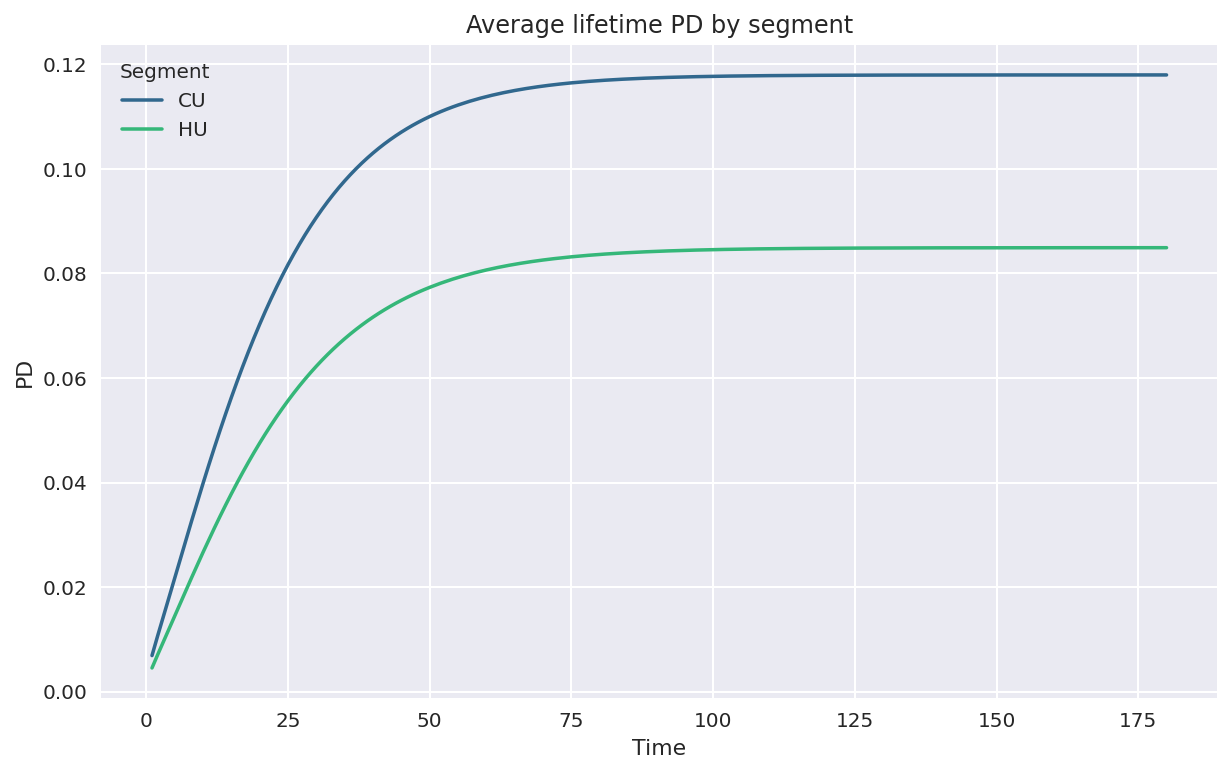

In [ ]:
# Plot
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Average lifetime PD by segment')
  sns.lineplot(x = 'times', y = 'averagePD',
               data = averageResult.drop(['N'], axis = 1).melt(id_vars = 'Segment',
                                                               var_name = 'times',
                                                               value_name = 'averagePD').sort_values(by = ['Segment', 'times']),
              hue = 'Segment', legend = 'full', palette = 'viridis', ci = None)
  plt.xlabel('Time')
  plt.ylabel('PD')
plt.savefig('averagePD.png')
plt.show()